<a href="https://colab.research.google.com/github/flanaganc04/My-own-Neural-Net/blob/main/Copy_of_Digit_Recognizer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
from google.colab import drive
import os
import datetime
# import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from tqdm.auto import tqdm

# Mount Google Drive

In [ ]:
# Mount Google Drive and try not to get yelled at
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np

class NeuralNet:
  def __init__(self, neurons, eta):
    self.neurons = neurons
    self.eta = eta

    self.weights_list = []              # [[W1], [W2], [W3], ...]
    self.biases_list = []               # [[b1], [b2], [b3], ...]
    self.layer_outputs_list = []        # [o1, o2, o3, ...]
    self.activation_derivs_list = []    # [o1', o2', o3', ...]
    self.weight_grads_list = []         # [dW1, dW2, dW3, ...]
    self.bias_grads_list = []           # [db1, db2, db3, ...]

    self.buildModel()

  def readData(self, train_data, test_data):
    X_train = train_data.iloc[:, 1:]
    X_train_np = X_train.to_numpy() * (1 / 255)
    Y_train = train_data.iloc[:, 0]
    Y_train_np = Y_train.to_numpy()

    X_test = test_data.iloc[:, 1:]
    X_test_np = X_test.to_numpy() * (1 / 255)
    Y_test = test_data.iloc[:, 0]
    Y_test_np = Y_test.to_numpy()

    return X_train_np, Y_train_np, X_test_np, Y_test_np

  def init_weight_matrix(self, inputNeurons, outputNeurons):
    weightMatrix = np.random.uniform(
        low=-1.0, high=1.0, size=(inputNeurons, outputNeurons)
    )
    return weightMatrix

  def init_bias_vector(self, neurons):
    bias = np.zeros((1, neurons))
    return bias

  def matrixMult(self, matrix, weightMatrix):
    product = matrix @ weightMatrix
    return product

  def softMax(self, matrix):
    matrixTemp = matrix.copy()  # Create a copy to avoid modifying the input
    expMatrix = np.exp(matrixTemp)
    sums = expMatrix.sum(axis=1, keepdims=True)
    softmax = expMatrix / (sums + 1e-9)  # avoids 0 division
    derivative = softmax * (1 - softmax)
    return softmax, derivative

  def relu(self, matrix):
    matrixTemp = matrix.copy()
    relu = np.maximum(0, matrixTemp)
    derivative = np.where(matrixTemp > 0, 1, 0)
    return relu, derivative

  def OneHotEncoder(self, matrix):
    matrix = matrix.astype(int).flatten()
    num_classes = 10
    one_hot_matrix = np.eye(num_classes)[matrix]
    return one_hot_matrix

  def CCE(self, y_train):
    # Gradient of the loss function
    Y_train_onehot = self.OneHotEncoder(y_train)
    output_square = Y_train_onehot

    if self.layer_outputs_list[-1] is None:
      raise RuntimeError("Run ForwardProp(X) before calling CCE.")

    # y_pred is last layer output
    y_pred = self.layer_outputs_list[-1]
    logOput = np.log(y_pred + 1e-9)  # avoid log(0)

    CCE = -np.sum((output_square * logOput), axis=1, keepdims=True)
    CCE_avg = np.mean(CCE)
    return CCE_avg

  def ForwardProp(self, X):
    """
    X: (batch_size, input_dim)
    """
    input = X
    L = len(self.weights_list)

    for i, (w, b) in enumerate(zip(self.weights_list, self.biases_list)):
      # affine
      z = self.matrixMult(input, w) + b

      if i != L - 1:
        # hidden layer: ReLU
        a, da = self.relu(z)
        self.layer_outputs_list[i] = a
        self.activation_derivs_list[i] = da
        input = a
      else:
        # output layer: Softmax
        a, da = self.softMax(z)
        self.layer_outputs_list[i] = a        # y_pred
        self.activation_derivs_list[i] = da
        input = a

    return input  # y_pred

  def BackProp(self, X_batch, y_batch):
    """
    Whole-network backprop using the same logic as the layer-level `backward`.

    X_batch: (m, n_input)
    y_batch: (m,) integer labels 0–9
    """

    # ----- 1. Forward pass to get predictions and cached activations -----
    y_pred = self.ForwardProp(X_batch)       # shape: (m, 10)
    m = X_batch.shape[0]

    # ----- 2. Top gradient: dL/da at the output layer -----
    # For Softmax + CCE, we have dL/dz = (y_pred - Y_true)/m.
    # If we treat the activation at the last layer as "identity" for backprop,
    # we can just start with dL_da = (y_pred - Y_true)/m and skip da_dz.
    Y_true = self.OneHotEncoder(y_batch)     # shape: (m, 10)
    dL_da = (y_pred - Y_true) / m            # this is our "incoming" gradient at last layer

    L = len(self.weights_list)

    # ----- 3. Iterate from last layer down to first -----
    for layer in range(L - 1, -1, -1):
        # ----- Identify layer-specific tensors -----
        W = self.weights_list[layer]         # (input_size, output_size)

        if layer == 0:
            last_input = X_batch             # input to first layer
        else:
            last_input = self.layer_outputs_list[layer - 1]  # a^{(layer)}

        # For hidden layers we stored f'(z) in activation_derivs_list.
        # For the last (softmax+CCE) layer, we effectively treat f'(z) = 1
        # because we already combined softmax + CCE into dL_da.
        if layer == L - 1:
            da_dz = 1.0                      # scalar broadcast; identity derivative
        else:
            da_dz = self.activation_derivs_list[layer]   # same shape as layer output

        # ----- Apply the same logic as your `backward` -----
        # dL_dz = dL/da * da/dz
        dL_dz = dL_da * da_dz                # (m, output_size)

        # gradient w.r.t. weights: last_input^T @ dL_dz
        weight_gradient = last_input.T @ dL_dz / 1.0     # we already divided by m in dL_da

        # gradient w.r.t. biases: sum over batch
        bias_gradient = np.sum(dL_dz, axis=0, keepdims=True)

        # gradient w.r.t. inputs: dL_dz @ W^T
        dL_da = dL_dz @ W.T                  # this becomes dL/da for the previous layer

        # store gradients
        self.weight_grads_list[layer] = weight_gradient
        self.bias_grads_list[layer]   = bias_gradient

    # ----- 4. Gradient descent step (since you’re not using an external optimizer yet) -----
    for i in range(L):
        self.weights_list[i] -= self.eta * self.weight_grads_list[i]
        self.biases_list[i]  -= self.eta * self.bias_grads_list[i]


  def buildModel(self):
    input_weights = self.init_weight_matrix(self.neurons[0], self.neurons[1])
    self.weights_list.append(input_weights)
    input_biases = self.init_bias_vector(self.neurons[1])
    self.biases_list.append(input_biases)

    hidden_weights = self.init_weight_matrix(self.neurons[1], self.neurons[2])
    self.weights_list.append(hidden_weights)
    hidden_biases = self.init_bias_vector(self.neurons[2])
    self.biases_list.append(hidden_biases)

    output_weights = self.init_weight_matrix(self.neurons[2], self.neurons[3])
    self.weights_list.append(output_weights)
    output_biases = self.init_bias_vector(self.neurons[3])
    self.biases_list.append(output_biases)

    # initialize storage for forward pass
    L = len(self.weights_list)
    self.layer_outputs_list = [None] * L
    self.activation_derivs_list = [None] * L
    self.weight_grads_list = [None] * L
    self.bias_grads_list = [None] * L

  def predict(self, X):
    """
    Runs a forward pass and returns predicted class labels.
    """
    y_pred = self.ForwardProp(X)           # softmax outputs
    return np.argmax(y_pred, axis=1)       # convert to class index


def train(model, X_train, y_train, batch_size, epochs):
    n_samples = X_train.shape[0]

    for epoch in range(epochs):
        # Shuffle indices
        perm = np.random.permutation(n_samples)
        X_shuf = X_train[perm]
        y_shuf = y_train[perm]

        epoch_loss_sum = 0.0

        # tqdm progress bar over samples in this epoch
        with tqdm(total=n_samples,
                  desc=f"Epoch {epoch+1}/{epochs}",
                  unit="sample") as pbar:

            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                X_batch = X_shuf[start:end]
                y_batch = y_shuf[start:end]

                # One training step (forward + backward + update)
                model.BackProp(X_batch, y_batch)

                # Compute batch loss for display
                _ = model.ForwardProp(X_batch)
                batch_loss = model.CCE(y_batch)

                batch_size_eff = end - start
                epoch_loss_sum += batch_loss * batch_size_eff

                # Update progress bar
                pbar.set_postfix(batch_loss=f"{batch_loss:.4f}")
                pbar.update(batch_size_eff)

        avg_epoch_loss = epoch_loss_sum / n_samples
        print(f"Epoch {epoch+1}/{epochs} - avg loss: {avg_epoch_loss:.4f}")

def evaluate(model, X_test, y_test):
  """
  Computes accuracy on the test set.
  """
  y_pred = model.predict(X_test)
  accuracy = np.mean(y_pred == y_test)
  print(f"Test Accuracy: {accuracy * 100:.2f}%")
  return accuracy



In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Digit Recognizer/mnist_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Digit Recognizer/mnist_test.csv')

neurons = [784,128,64,10]   #[n_1,n_2,n_2...n_i]
eta = 0.1                   #learning rate

In [ ]:
net = NeuralNet(neurons = neurons, eta = eta)
X_train, y_train, X_test, y_test = net.readData(train_data, test_data)

train(
    model = net,
    X_train = X_train,
    y_train = y_train,
    batch_size = 64,
    epochs = 5
)

# now test accuracy



Epoch 1/5:   0%|          | 0/60000 [00:00<?, ?sample/s]

Epoch 1/5 - avg loss: 0.9338


Epoch 2/5:   0%|          | 0/60000 [00:00<?, ?sample/s]

Epoch 2/5 - avg loss: 0.3694


Epoch 3/5:   0%|          | 0/60000 [00:00<?, ?sample/s]

Epoch 3/5 - avg loss: 0.2733


Epoch 4/5:   0%|          | 0/60000 [00:00<?, ?sample/s]

Epoch 4/5 - avg loss: 0.2283


Epoch 5/5:   0%|          | 0/60000 [00:00<?, ?sample/s]

Epoch 5/5 - avg loss: 0.2011


[7 2 1 0 4 1 4 9 6 9]
[0 6 9 0 1 5 9 7 5 4]




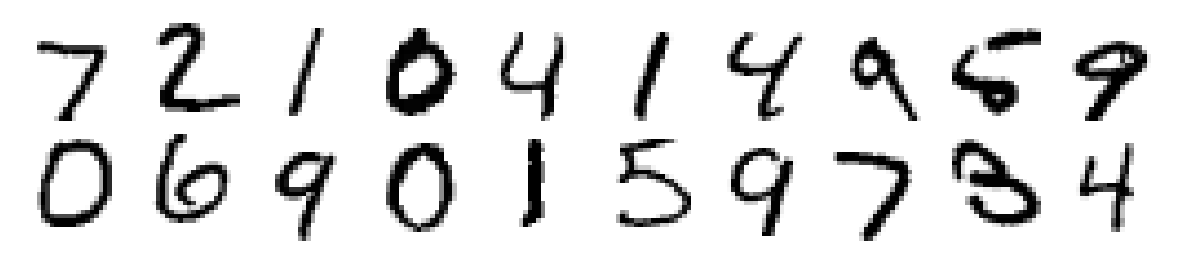

In [ ]:
pred = net.predict(X_test)

plt.figure(figsize=(15,4.5))
for i in range(20):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)

print(pred[0:10])
print(pred[10:20])
print("\n")

In [ ]:
evaluate(net, X_test, y_test)

Test Accuracy: 89.83%


np.float64(0.8983)

In [ ]:
net = NeuralNet(neurons = neurons, eta = eta)
X_train, y_train, X_test, y_test = net.readData(train_data, test_data)

train(
    model = net,
    X_train = X_train,
    y_train = y_train,
    batch_size = 64,
    epochs = 10
)
evaluate(net, X_test, y_test)

In [ ]:
net = NeuralNet(neurons = neurons, eta = eta)
X_train, y_train, X_test, y_test = net.readData(train_data, test_data)

train(
    model = net,
    X_train = X_train,
    y_train = y_train,
    batch_size = 64,
    epochs = 20
)
evaluate(net, X_test, y_test)


In [ ]:
net = NeuralNet(neurons = neurons, eta = eta)
X_train, y_train, X_test, y_test = net.readData(train_data, test_data)

train(
    model = net,
    X_train = X_train,
    y_train = y_train,
    batch_size = 64,
    epochs = 50
)
evaluate(net, X_test, y_test)

In [ ]:
net = NeuralNet(neurons = neurons, eta = eta)
X_train, y_train, X_test, y_test = net.readData(train_data, test_data)

train(
    model = net,
    X_train = X_train,
    y_train = y_train,
    batch_size = 64,
    epochs = 100
)
evaluate(net, X_test, y_test)

In [ ]:
net = NeuralNet(neurons = neurons, eta = eta)
X_train, y_train, X_test, y_test = net.readData(train_data, test_data)

train(
    model = net,
    X_train = X_train,
    y_train = y_train,
    batch_size = 16,
    epochs = 5
)
evaluate(net, X_test, y_test)

In [ ]:
net = NeuralNet(neurons = neurons, eta = eta)
X_train, y_train, X_test, y_test = net.readData(train_data, test_data)

train(
    model = net,
    X_train = X_train,
    y_train = y_train,
    batch_size = 32,
    epochs = 5
)
evaluate(net, X_test, y_test)

In [ ]:
net = NeuralNet(neurons = neurons, eta = eta)
X_train, y_train, X_test, y_test = net.readData(train_data, test_data)

train(
    model = net,
    X_train = X_train,
    y_train = y_train,
    batch_size = 128,
    epochs = 5
)
evaluate(net, X_test, y_test)

In [ ]:
net = NeuralNet(neurons = neurons, eta = eta)
X_train, y_train, X_test, y_test = net.readData(train_data, test_data)

train(
    model = net,
    X_train = X_train,
    y_train = y_train,
    batch_size = 256,
    epochs = 5
)
evaluate(net, X_test, y_test)

In [ ]:
epochs = [5, 10, 20, 50, 100]
batches = [16, 32 ,64, 128, 256]
epoch_accuracies = [0.8983, 0.9342, 0.9472, 0.9556, 0.9568]
batch_accuracies = [0.945, 0.9337, 0.8983, 0.8809, 0.8362]

Text(0, 0.5, 'Accuracy')

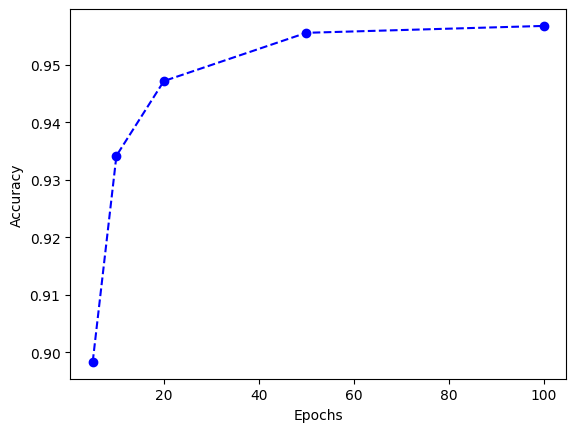

In [ ]:
plt.plot(epochs, epoch_accuracies, 'bo', linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

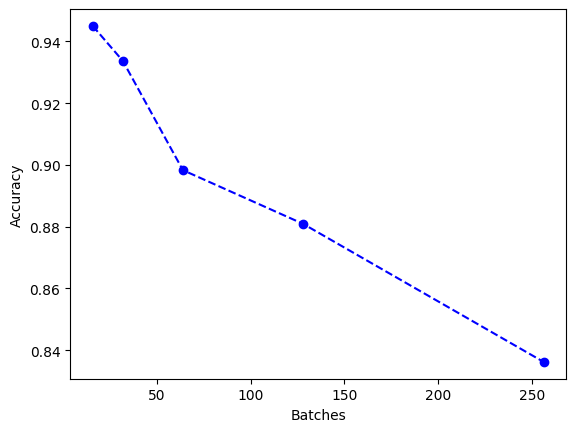

In [ ]:
plt.plot(batches, batch_accuracies, 'bo', linestyle = '--')
plt.xlabel('Batches')
plt.ylabel('Accuracy')